<a href="https://colab.research.google.com/github/kassy75035/1st-PyCrawlerMarathon/blob/master/Day081_Regularization_%E4%BD%9C%E6%A5%AD_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
from tensorflow import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [9]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128],l1_ratio=1e-4, l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [10]:
# Use L1 regularization
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio, l2_ratio=0)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = (f"Regularizer ratio: {regulizer_ratio}")
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896     
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
196/196 [==============================] - 12s 58ms/step - loss: 198.6660 - accuracy: 0.2369 - val_loss: 41.2414 - val_accuracy: 0.2663
Epoch 2/50
196/196 [==============================] - 11s 58ms/step - loss: 19.1978 - accuracy: 0.1201 - val_loss: 7.3200 - val_accuracy: 0.1000
Epoch 3/50
196/196 [==============================] - 11s 57ms/step - loss: 4.1150 - accuracy: 0.0991 - val_loss: 2.6513 - val_accuracy: 0.1000
Epoch 4/50
196/196 [==============================] - 11s 57ms/step - loss: 2.4871 - accuracy: 0.0967 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 5/50
196/196 [==============================] - 11s 58ms/step - loss: 2.4626 - accuracy: 0.0986 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 6/50
196/196 [==============================] - 11s 57ms/step - loss: 2.4626 - accuracy: 0.0970 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 7/50
196/196 [==============================] - 11s 57ms/step - loss: 2.4626 - accuracy: 0.0978 - val_loss: 2.4624 - val_accur

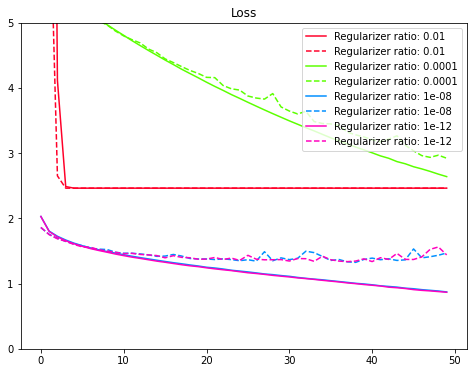

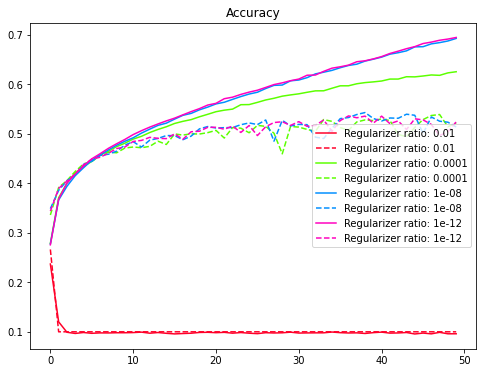

In [12]:
from matplotlib import cm as mplcm
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
"""Code Here
將結果繪出
"""
NUM_COLORS = 4

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()